In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats

In [20]:
import numpy as np
import pandas as pd

In [21]:
import datetime as dt
# from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [23]:
from sqlalchemy.sql import label

In [24]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# Engine connection for queries
connection = engine.connect()

In [26]:
# Reflect an existing database into a new model

# Declare a Base using `automap_base()`
Base = automap_base()

# Reflect the tables via use of Base class 
Base.prepare(engine, reflect=True)

In [27]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
measurement =  Base.classes.measurement
station = Base.classes.station

In [29]:
# Identify columns in each table
inspector = inspect(engine)

print("Measurement Table Columns")
m_columns = inspector.get_columns('measurement')
for column in m_columns:
    print(column["name"], column["type"])

print ('\nStation Table Columns')
s_columns = inspector.get_columns('station')
for column in s_columns:
    print(column["name"], column["type"])

Measurement Table Columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station Table Columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Identify the max date in the database
last_date = session.query(func.max(measurement.date)).all()[0][0]
#print(f'The max date in the dataset is: {last_date}, its type is {type(last_date)} \n')

# Convert date to datetime format
dt_max_date = dt.datetime.strptime(last_date, '%Y-%m-%d')

# Calculate the date 1 year prior to last date in database
date_year_prior = dt_max_date - dt.timedelta(days=365)
#print(f'365 days prior to last date in dataset: {year_prior.date()} \n')

# Perform a query to retrieve the data and precipitation scores, filtering out null values
results = (session.query(measurement.date, measurement.prcp).
           filter(measurement.date>=date_year_prior).
           filter(measurement.prcp != None).
           all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(results, columns=['Date','Precipitation'])
c_precipitation_df = precipitation_df

# Format Date column to date time
c_precipitation_df['Date'] = pd.to_datetime(c_precipitation_df['Date'], yearfirst=True)

# Sort the dataframe by date
sorted_precip = c_precipitation_df.sort_values(by=['Date'])
sorted_precip

,Date,Precipitation
0,2016-08-24,0.08
1024,2016-08-24,1.22
700,2016-08-24,2.28
1688,2016-08-24,1.45
358,2016-08-24,2.15
...,...,...
2013,2017-08-22,0.50
357,2017-08-23,0.00
1336,2017-08-23,0.08
963,2017-08-23,0.00


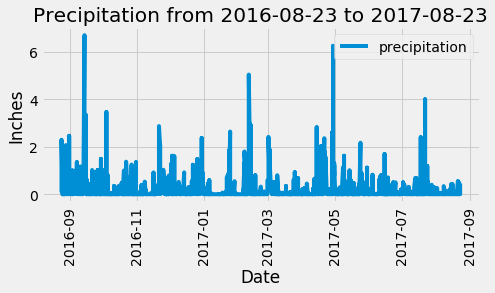

In [32]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7,3))
plt.plot(sorted_precip['Date'], sorted_precip['Precipitation'])
plt.title(f'Precipitation from {date_year_prior.date()} to {last_date}')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Inches')
plt.legend(['precipitation'], loc='upper right')
plt.show()

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_df = sorted_precip[['Precipitation']].agg(['mean', 'median', 'var', 'std', 'sem'])
summary_df

,Precipitation
mean,0.176462
median,0.020000
var,0.211865
std,0.460288
sem,0.010254


In [34]:
# Design a query to show how many stations are available in this dataset
station_results = session.query(func.count(station.station)).all()
station_results

[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_freq = (session.query(station.station, func.count(measurement.station).label('station_count')).
                filter(station.station == measurement.station).
                group_by(station.name).
                order_by(sqlalchemy.desc('station_count')).
                all())
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

max_count_station = station_freq[0][0]

station_temp = (session.query(measurement.station, 
                                func.min(measurement.tobs).label('min_temp'), 
                                func.max(measurement.tobs).label('max_temp'), 
                                func.avg(measurement.tobs).label('average_temp')).
                    filter(station.station == max_count_station ).
                    all())
station_temp

[('USC00519397', 53.0, 87.0, 73.09795396419437)]

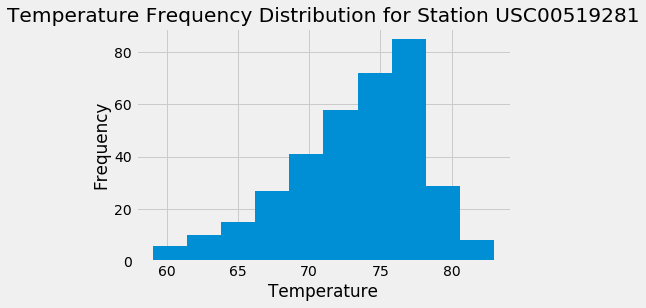

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_year_temp = (session.query(measurement.tobs).
                    filter(measurement.date >= date_year_prior).
                    filter(measurement.station == max_count_station).
                    all())

station_year_temp_df = pd.DataFrame(station_year_temp, columns=['tobs'])
station_year_temp_df = station_year_temp_df.dropna()

# Result Plot
plt.hist(station_year_temp_df['tobs'])
plt.title(f'Temperature Observation Distribution for Station {max_count_station }')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I - Hypothesis Testing ###

In [180]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.

month = func.strftime("%m", measurement.date).label('month')

june_dec_temp = (session.query(month, measurement.tobs).
                filter((month == '06') | 
                (month == '12')).
                all())

june_dec_temp_df = pd.DataFrame(june_dec_temp, columns=['month', 'temperature'])
june_dec_means = (june_dec_temp_df.groupby('month').mean().
                  rename(columns={'temperature':'temp average'}))
june_dec_means 

,temp average
month,
06,74.944118
12,71.041529


In [191]:
# Paired T-Test
june = june_dec_temp_df.loc[june_dec_temp_df['month'] == '06']
dec = june_dec_temp_df.loc[june_dec_temp_df['month'] == '12']

stats.ttest_ind(june['temperature'], dec['temperature'])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

** Hypothesis Review, Reasoning for a Independent-T Test, and Result Analysis**


### Temperature Analysis II - Trip Average Temperature ###

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
years_t_data = calc_temps(date_year_prior, last_date)

tavg = years_t_data[0][1]
tmin = years_t_data[0][0]
tmax = years_t_data[0][2]

years_t_data

[(58.0, 74.57894736842105, 87.0)]

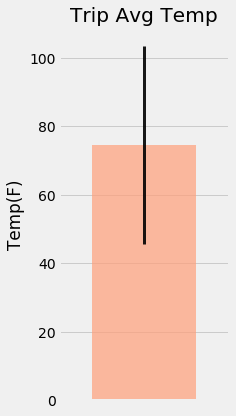

In [174]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

t_avg_df = pd.DataFrame({'Temperature Average': [tavg]})
tick_loc = [1]

t_avg_df.plot(kind='bar', 
              width=.8, 
              color='lightsalmon', 
              legend=False, figsize=(3.5,6), 
              alpha=.7)

# Plotted error bar separately to manipulate format
plt.errorbar(x=0, 
             y=(tavg), 
             yerr=[tmax-tmin], 
             linewidth=3,
             color='black',
             alpha=.9)

plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.xticks(tick_loc)
plt.tight_layout()
plt.show()

### Temperature Analysis III - Daily Normals ###

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_by_station = (session.query(station.name, func.sum(measurement.prcp).label('total_rainfall')).
                        filter(station.station == measurement.station).
                        filter(measurement.date >= date_year_prior).
                        group_by(measurement.station).
                        order_by(sqlalchemy.desc("total_rainfall")).
                        all())

rainfall_by_station

[('MANOA LYON ARBO 785.2, HI US', 147.11000000000004),
 ('WAIHEE 837.5, HI US', 68.24000000000002),
 ('KANEOHE 838.1, HI US', 48.36000000000003),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 37.99),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 33.19),
 ('WAIKIKI 717.2, HI US', 16.089999999999986),
 ('PEARL CITY, HI US', 4.59)]

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    session.close()
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [80]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
date_list = []
month_day_list = []
normals_list = []

# Set the start and end date of the trip
start_date= dt.date(2017, 1, 1)  
end_date= dt.date(2017, 1, 15)  

# time delta 
delta = end_date - start_date           

# Use the start and end date to create a range of dates
for i in range(delta.days + 1):
    date = (start_date + dt.timedelta(i))
    date_list.append(date)
    date = date.strftime('%m-%d')
# Strip off the year and save a list of %m-%d strings
    month_day_list.append(date)


# Loop through the list of %m-%d strings and calculate the normals for each date
for date in month_day_list:
    normal_val = daily_normals(date)
    normals_list.append(normal_val[0])

normals_list

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0)]

In [114]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.DataFrame(normals_list, columns=['tmin', 'tavg', 'tmax'])
trip_dates['dates'] = date_list
trip_dates = trip_dates.set_index('dates')
trip_dates

,tmin,tavg,tmax
dates,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0


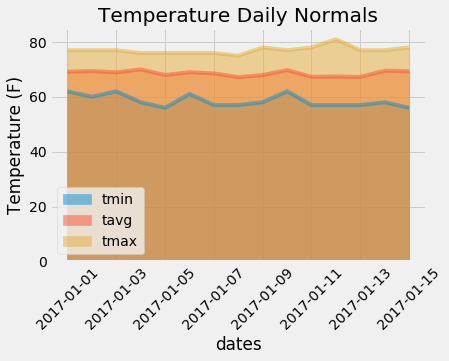

In [192]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.title('Temperature Daily Normals')
plt.ylabel('Temperature (F)')
plt.show()

In [214]:
start = '2017-01-01'
single_date = dt.datetime.strptime(start, '%Y-%m-%d')
print(single_date)

session = Session(engine)

sel = [measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
single_date_data_return = (session.query(*sel).filter(func.strftime("%Y-%m-%d", measurement.date) == start).all())
single_date_data_return

2017-01-01 00:00:00


[('2017-01-01', 62.0, 69.33333333333333, 74.0)]

In [220]:
single_date_data_return[0]

('2017-01-01', 62.0, 69.33333333333333, 74.0)

In [237]:
test = {}

for row in single_date_data_return:
      test[row[0]] = [{'min temp':row[1], 'avg temp': row[2], 'max temp':row[3]}]
test

{'2017-01-01': [{'min temp': 62.0,
   'avg temp': 69.33333333333333,
   'max temp': 74.0}]}

In [236]:
for row in single_date_data_return:
    test[row[0]] =  {['min temp':row[1]], ['avg temp': row[2]], ['max temp':row[3]]} 

SyntaxError: invalid syntax (<ipython-input-236-1f49e0d38707>, line 2)

In [235]:
test

{'2017-01-01': [{'min temp': 62.0,
   'avg temp': 69.33333333333333,
   'max temp': 74.0}]}

In [238]:
# last_date = session.query(func.max(measurement.date)).all()[0][0]

if start > last_date:
    print('No such date')
else:
    print('date available')
#print(f'The max date in the dataset is: {last_date}, its type is {type(last_date)} \n')

# Convert date to datetime format
# dt_max_date = dt.datetime.strptime(last_date, '%Y-%m-%d')

date available


In [ ]:
return {jsonify({"error": f"Date input {start} has no data available"})}

In [240]:
print(last_date)

2017-08-23


In [245]:
first_date = session.query(func.min(measurement.date)).all()[0][0]
        
start = '1800-01-01'
if start > last_date or start < first_date:
    print('No such date')
else:
    print('date available')

No such date


In [ ]:
{jsonify({"error": f"Date input {start} has no data available"}), 404}
return {jsonify({"error": f"Date input {start} has no data available"})}

In [264]:
dates = session.query(measurement.date).all()

start= '2017-01-01'
date_available = True

date_available = [False if start not in dates else True]
date_available
# print(start)

[False]

In [279]:
last_date =  dt.datetime.strptime((session.query(func.max(measurement.date)).all()[0][0]), "%Y-%m-%d")
last_date
# last_datea = session.query(func.max(measurement.date)).all()[0][0]

datetime.datetime(2017, 8, 23, 0, 0)

In [286]:
# start_date = dt.datetime.strptime(start, "%Y-%m-%d")
last_datea =  session.query(func.max(measurement.date)).all()[0][0]
# last_datea
# last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")

SyntaxError: invalid character in identifier (<ipython-input-286-7ec105c09ad3>, line 2)

In [290]:
last_date = (session.query(func.max(measurement.date)).all()[0][0])

In [287]:
last_date =  session.query(func.max(measurement.date)).all()[0][0]

In [293]:
last_date =(session.query(func.max(measurement.date)).all()[0][0])

SyntaxError: invalid character in identifier (<ipython-input-293-2764df906142>, line 1)

In [385]:
start = 'June 1 2017'
try:
    sel = [measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    single_date_data_return = (session.query(*sel).filter(func.strftime("%Y-%m-%d", measurement.date) == start).all())

    station_temp_dict = {}
    for row in single_date_data_return:
        station_temp_dict[row[0]] =  {'min temp':row[1], 'avg temp': row[2], 'max temp':row[3]}

    jsonified_single_date_data_return = station_temp_dict

    session.close

    if station_temp_dict.keys()[0] == None:
        null_valls = {"TEST": 404, "error": f"Date input {start} is not in correct format (YYYY-MM-dd)."}
        print (null_valls)

    else:
        print(jsonified_single_date_data_return)

except TypeError:
    print({"error": f"Date input {start} is not in correct format (YYYY-MM-dd)."})

{'error': 'Date input June 1 2017 is not in correct format (YYYY-MM-dd).'}


In [329]:
try:
        session = Session(engine)

        sel = [measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
        single_date_data_return = (session.query(*sel).filter(func.strftime("%Y-%m-%d", measurement.date) == start).all())

        station_temp_dict = {}
        for row in single_date_data_return:
            if row[0] == None:
                station_temp_dict[row[0]] =  {'min temp':None, 'avg temp': None, 'max temp':None}
            else:
                station_temp_dict[row[0]] =  {'min temp':row[1], 'avg temp': row[2], 'max temp':row[3]}

        jsonified_single_date_data_return = station_temp_dict

        session.close

        if station_temp_dict.keys()[0] == None:
            null_vals = jsonify({"start": f"Date input {start} is not in correct format (YYYY-MM-dd)."}, 404)
            print(null_vals)

        else:
            print(jsonified_single_date_data_return)

except TypeError:
    print({f"error": f"Date input {start} is not in correct format (YYYY-MM-dd)."}, 404)

RuntimeError: Working outside of application context.

This typically means that you attempted to use functionality that needed
to interface with the current application object in some way. To solve
this, set up an application context with app.app_context().  See the
documentation for more information.

In [374]:
start= '2000-01-01'

sel = [measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
single_date_data_return = (session.query(*sel).filter(func.strftime("%Y-%m-%d", measurement.date) == start).all())

station_temp_dict = {}
for row in single_date_data_return:
    station_temp_dict[row[0]] =  {'min temp':row[1], 'avg temp': row[2], 'max temp':row[3]}

    jsonified_single_date_data_return = station_temp_dict

#     if station_temp_dict.keys()[0] == None:
#         null_vals = {"error class": 404, "error": f"Date input {start} is not available in the database."}
#         print(null_vals)
        
#     else:
#         print (jsonified_single_date_data_return)

if station_temp_dict.keys() == np.nan:
    null_vals = {"error class": 404, "error": f"Date input {start} is not available in the database."}
    print (null_vals)
else:
    print('ehh')

ehh


In [383]:
mydict = {
"a":"alpha",
"b":0,
"c":False,
"d":None,
"e":"",
"g":"   ",
}

for key in key, value in station_temp_dict.items:
    v = station_temp_dict.get(key)
    if v and v.strip():
        print(key,"I am here and have stuff")
    else:
        print(key,"I am incomplete and sad")

a I am here and have stuff
alpha
b I am incomplete and sad
c I am incomplete and sad
d I am incomplete and sad
e I am incomplete and sad


In [384]:
sel = [measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
single_date_data_return = (session.query(*sel).filter(func.strftime("%Y-%m-%d", measurement.date) == 'June').all()).filter()
single_date_data_return

[(None, None, None, None)]

In [387]:
sel = [measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
single_date_data_return = (session.query(*sel).filter(func.strftime("%Y-%m-%d", measurement.date) == start).all())

station_temp_dict = {}
date_list = []

print(single_date_data_return[0][0])

None


In [40]:
dates = session.query(func.max(measurement.date), func.min(measurement.date)).all()[0]
dates

('2017-08-23', '2010-01-01')